In [1]:
# import os
# for item in sorted(os.listdir()):
#     print(item)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# tf.enable_eager_execution()

---

Original version

In [ ]:
# from tensorflow.examples.tutorials.mnist import input_data

In [49]:
# def init_weights(shape):
#     return tf.Variable(tf.random_normal(shape, stddev=0.01))

# def model(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden): 
#     # this network is the same as the previous one except with an extra hidden layer + dropout
#     # dropout means we randomly deactivate certain neurons and force the network to keep
#     # doing its job
#     # p_keep_input and p_keep_hidden are the probabilities of cells being preserved
    
#     X = tf.nn.dropout(X, p_keep_input)
#     h = tf.nn.relu(tf.matmul(X, w_h))

#     h = tf.nn.dropout(h, p_keep_hidden)
#     h2 = tf.nn.relu(tf.matmul(h, w_h2))

#     h2 = tf.nn.dropout(h2, p_keep_hidden)

#     return tf.matmul(h2, w_o)

# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [43]:
# X = tf.placeholder("float", [None, 784])
# Y = tf.placeholder("float", [None, 10])

# w_h = init_weights([784, 625])
# w_h2 = init_weights([625, 625])
# w_o = init_weights([625, 10])

# p_keep_input = tf.placeholder("float")
# p_keep_hidden = tf.placeholder("float")
# py_x = model(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden)

# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=py_x, labels=Y))
# train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
# predict_op = tf.argmax(py_x, 1)

In [45]:
# # Launch the graph in a session
# with tf.Session() as sess:
#     # you need to initialize all variables
#     tf.global_variables_initializer().run()

#     for i in range(5):
#         for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
#             sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
#                                           p_keep_input: 0.8, p_keep_hidden: 0.5})
#         print(i, np.mean(np.argmax(teY, axis=1) ==
#                          sess.run(predict_op, feed_dict={X: teX, Y: teY,
#                                                          p_keep_input: 1.0,
#                                                          p_keep_hidden: 1.0})))

0 0.9302
1 0.963
2 0.9702
3 0.9724
4 0.9737


---

Reworked version

In [2]:
tf.reset_default_graph()

In [3]:
# To avoid the deprecation warning when importing MNIST, trying the Keras method found here:
# https://www.tensorflow.org/tutorials/
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
trX = tf.reshape(x_train, [-1, 784])
trY = tf.one_hot(y_train, 10)
teX = tf.reshape(x_test, [-1, 784])
teY = tf.one_hot(y_test, 10)

In [5]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [6]:
# Input & output
X = tf.placeholder("float", [None, 784])
Y = tf.placeholder("float", [None, 10])

# Dropout for input layer, for hidden layers
dropout_in = tf.placeholder("float")
dropout_h = tf.placeholder("float")

In [7]:
# Must start with 784 (pixels) and end with 10 (classes)
layers = [784, 425, 310, 200, 10]

weights = []
for i in range(len(layers[:-1])):
    w_i = init_weights([layers[i], layers[i+1]])
    weights.append(w_i)

In [8]:
for weight in weights:
    print(weight.shape)

(784, 425)
(425, 310)
(310, 200)
(200, 10)


In [9]:
def model(X, weights, dropout_in, dropout_h):
    
    current_layer = X
    current_layer = tf.nn.dropout(current_layer, dropout_in)
    
    for i, weights_i in enumerate(weights[:-1]):
        h = tf.nn.relu(tf.matmul(current_layer, weights_i))
        h = tf.nn.dropout(h, dropout_h)
        current_layer = h
        
    return tf.matmul(current_layer, weights[-1])

In [10]:
py_x = model(X, weights, dropout_in, dropout_h)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=py_x, labels=Y))
# train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
train_op = tf.train.AdamOptimizer(0.001).minimize(cost)
predict_op = tf.argmax(py_x, 1)

Iteration: 0 | Cost: 0.32928622 | Accuracy: 0.9366
Iteration: 2 | Cost: 0.2056875 | Accuracy: 0.9666
Iteration: 4 | Cost: 0.17500618 | Accuracy: 0.9727
Iteration: 6 | Cost: 0.15877767 | Accuracy: 0.9744
Iteration: 8 | Cost: 0.15470918 | Accuracy: 0.9766
Iteration: 10 | Cost: 0.14889982 | Accuracy: 0.9794
Iteration: 12 | Cost: 0.14470638 | Accuracy: 0.9795
Iteration: 14 | Cost: 0.15630338 | Accuracy: 0.9799
Iteration: 16 | Cost: 0.14514285 | Accuracy: 0.9804
Iteration: 18 | Cost: 0.13551044 | Accuracy: 0.9822


Text(0,1,'Accuracy')

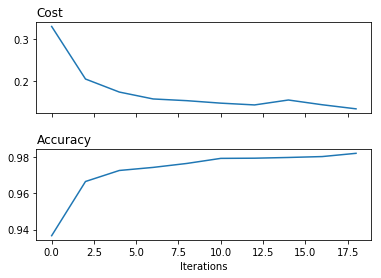

In [11]:
# Launch the graph in a session
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    trX = trX.eval()
    trY = trY.eval()
    teX = teX.eval()
    teY = teY.eval()
    
    cost_evolution = []
    accuracy_evolution = []
    
    for i in range(20):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            
            sess.run(train_op, feed_dict={X: trX[start:end], 
                                          Y: trY[start:end],
                                          dropout_in: 0.8, 
                                          dropout_h: 0.5})
            
        if i % 2 == 0:
            cost_i = sess.run(cost, feed_dict = {X: teX,
                                                 Y: teY,
                                                 dropout_in:0.8,
                                                 dropout_h: 0.5})
            cost_evolution.append((i, cost_i))
            
            acc_i = np.mean(np.argmax(teY, axis=1) == 
                            sess.run(predict_op, feed_dict= {X: teX,
                                                             Y: teY,
                                                             dropout_in: 1.0,
                                                             dropout_h: 1.0}))
            accuracy_evolution.append((i, acc_i))
                    
            print('Iteration:', i, '| Cost:', cost_i,'| Accuracy:', acc_i)

#Creates two subplots for the cost and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.4)
ax1.plot(*zip(*cost_evolution))
ax1.set_title('Cost', loc='left')
ax2.set_xlabel('Iterations')
ax2.plot(*zip(*accuracy_evolution))
ax2.set_title('Accuracy', loc='left')